In [1]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import matplotlib.ticker as ticker
from matplotlib.transforms import ScaledTranslation
import pandas as pd
from pandas_ods_reader import read_ods
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
### Forçantes calculadas levando em consideração as irradiâncias corrigidas pela NOAA e a média conjunta dos 
### dias mais limpos de 2014 e 2015. Essas são as forçantes para "12:00LT", ou para SZA=0°, ou quando mu0=1:

irfs_12lt = pd.read_pickle('/mnt/HD_500GB_WD/historia2/forcantesGoAmazon_refconjunta_diarias_model4_comfiltro_12LT.pkl')

### Forçantes DIURNAS (06:00 às 18:00):

In [5]:
################################################################### PARA 2014:
### Carregando as planilhas da NOAA para o ano de 2014: 
path = '/mnt/HD_500GB_WD/historia2/ZZ-TabelasNOAA/'

arqs = sorted(glob.glob(path+'NOAA_???.ods'))
tabelas14 = []
for i in range(len(arqs)):
#     print(arqs[i])
    df = read_ods(arqs[i], 1, headers=True)
    tabn = df[['Date', 'Time (past local midnight)', 'Solar Zenith Angle (deg)']]
    tabelas14.append(tabn)
    
### Guardando os dataframes com o período diurno (06:00 às 18:00) de 2014:
tabelas14_periodo_diurno = [tabn.loc[59:179] for tabn in tabelas14]

### Loop para guardar as razões (somatórias diárias diurnas do mu0/quantidade de mu0's) do período 
### diurno (06:00 às 18:00) de 2014:
razoes_mu0_diarias_diurnas_2014 = []
for k in range(len(tabelas14_periodo_diurno)):
    sza_radianos = (tabelas14_periodo_diurno[k]['Solar Zenith Angle (deg)'])*(np.pi/180)
    mu0 = np.cos(sza_radianos)
    somatoria_mu0_diak = np.sum(mu0)
    razoes_mu0_diarias_diurnas_2014.append(somatoria_mu0_diak/len(mu0))
    
### Loop para guardar as IRF_medias_diarias_diurnas = IRF_12LT*(somatórias diárias diurnas do mu0/quantidade de
### mu0's) de 2014:
irfs_medias_dias_diurnas_2014 = []
for k in range(len(irfs_12lt['IRF_12LT'].loc[:364])):
    irf_media_diak_diurna = irfs_12lt['IRF_12LT'][k]*razoes_mu0_diarias_diurnas_2014[k]
    irfs_medias_dias_diurnas_2014.append(irf_media_diak_diurna)

In [6]:
################################################################### PARA 2015:
### Carregando as planilhas da NOAA para o ano de 2015: 
path = '/mnt/HD_500GB_WD/historia2/ZZ-TabelasNOAA/2015/'

arqs = sorted(glob.glob(path+'NOAA_???.ods'))
tabelas15 = []
for i in range(len(arqs)):
#     print(arqs[i])
    df = read_ods(arqs[i], 1, headers=True)
    tabn = df[['Date', 'Time (past local midnight)', 'Solar Zenith Angle (deg)']]
    tabelas15.append(tabn)
    
### Guardando os dataframes com o período diurno (06:00 às 18:00) de 2015:
tabelas15_periodo_diurno = [tabn.loc[59:179] for tabn in tabelas15]

### Loop para guardar as razões (somatórias diárias diurnas do mu0/quantidade de mu0's) do período 
### diurno (06:00 às 18:00) de 2015:
razoes_mu0_diarias_diurnas_2015 = []
for k in range(len(tabelas15_periodo_diurno)):
    sza_radianos = (tabelas15_periodo_diurno[k]['Solar Zenith Angle (deg)'])*(np.pi/180)
    mu0 = np.cos(sza_radianos)
    somatoria_mu0_diak = np.sum(mu0)
    razoes_mu0_diarias_diurnas_2015.append(somatoria_mu0_diak/len(mu0))
    
### Loop para guardar as IRF_medias_diarias_diurnas = IRF_12LT*(somatórias diárias diurnas do mu0/quantidade de
### mu0's) de 2015:
irfs_medias_dias_diurnas_2015 = []
for k, v in enumerate(irfs_12lt['IRF_12LT'].loc[365:]):
    irf_media_diak_diurna = v*razoes_mu0_diarias_diurnas_2015[k]
    irfs_medias_dias_diurnas_2015.append(irf_media_diak_diurna)

In [7]:
######################################### PARA 2014 e 2015 juntos:
irfs_medias_diurnas_goamazon = irfs_medias_dias_diurnas_2014+irfs_medias_dias_diurnas_2015

### Forçantes DIÁRIAS (00:00 às 23:54):

In [8]:
######################################### PARA 2014 e 2015 juntos:
irfs_medias_diarias_goamazon = np.array(irfs_medias_diurnas_goamazon)/2

### Multiplicando as IRF medias diárias e diurnas completas (2014+2015) pelo valor de Cloud Fraction DIÁRIO e DIURNO:

In [9]:
### Pasta com os dataframes com as médias de minuto em minuto para Cloud_Fraction:
directory0 = '/mnt/HD_500GB_WD/00_Doutorado/Codigos_Notebooks_Medias_Resample/Dataframes_Media1m/'
cf = pd.read_pickle(directory0+'flux1longM1_cloudfraction_shortwave_df_T_dias_raw_1m.pkl')

In [10]:
### Função para padronizar o formato do índice (minutos) e das datas nas colunas dos dataframes
### (padrão: '01/01/2015'):
def padroniza_datas(df):
    mins = np.arange(0, 1440, 1)
    datas = list(df.columns)
    datas_arrumadas = []
    for dia in datas:
        if len(dia)==10:
            datas_arrumadas.append(dia)
        elif len(dia)==8:
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]=='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(0,'0')
            datas_arrumadas.append(''.join(ltemp))
        elif len(dia)==9 and dia[1]!='/':
            ltemp = []
            for c in dia:
                ltemp.append(c)
            ltemp.insert(3,'0')
            datas_arrumadas.append(''.join(ltemp))
    df.columns = datas_arrumadas
    df.index = mins
    df.index.name = "tempo"
    df.columns.name = "dias"
    
padroniza_datas(cf)

In [11]:
### Função que constrói o dataframe com as datas do GoAmazon (01/01/14 a 31/12/15) cheio de NaN's. Depois disso
### insere os dias de 2014 e de 2015 faltantes nos dataframes dos dados:
freq = 1440

def completa_dias_goamazon(df):
    days = pd.date_range(start="2014-01-01", end='2015-12-31',freq='D').strftime('%d/%m/%Y')
    mins = np.arange(0, freq, 1)
    df_nans = pd.DataFrame(columns=days, index=mins)    
    booleanos = []
    for dia in list(df_nans.columns):
        booleanos.append(dia in list(df.columns))
    for i in range(len(booleanos)):
        if booleanos[i] == True:     # Há dados neste dia
            pass
        elif booleanos[i] == False:  # Não há dados neste dia
            df.insert(i, column=df_nans.columns[i], value=df_nans.T.iloc[i].values)
            
completa_dias_goamazon(cf)

In [12]:
#################################################### IRF_diária * CF_diário (00:00 às 23:54):
medias_cfs_diarios = []
for col in cf.columns:
    medias_cfs_diarios.append(np.mean(cf[col]))
    
irfs_medias_diarias_goamazon_com_cfdiaria = np.multiply(medias_cfs_diarios, irfs_medias_diarias_goamazon)
len(irfs_medias_diarias_goamazon_com_cfdiaria)

730

In [13]:
#################################################### IRF_diurna * CF_diurna (06:00 às 18:00):
cf_diurno = cf.loc[359:1078]

medias_cfs_diurnos = []
for col in cf_diurno.columns:
    medias_cfs_diurnos.append(np.mean(cf_diurno[col]))
    
irfs_medias_diurnas_goamazon_com_cfdiurna = np.multiply(medias_cfs_diurnos, irfs_medias_diurnas_goamazon)
len(irfs_medias_diurnas_goamazon_com_cfdiurna)

730

In [14]:
dic = {'irf_diurna_scf':list(irfs_medias_diurnas_goamazon),
       'irf_diaria_scf':list(irfs_medias_diarias_goamazon),
       'irf_diurna_ccf':list(irfs_medias_diurnas_goamazon_com_cfdiurna),
       'irf_diaria_ccf':list(irfs_medias_diarias_goamazon_com_cfdiaria)}
dt = pd.DataFrame(dic)
# directory = '/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/'
# dt.to_pickle(directory+'irfs_finais_goamazon.pkl')

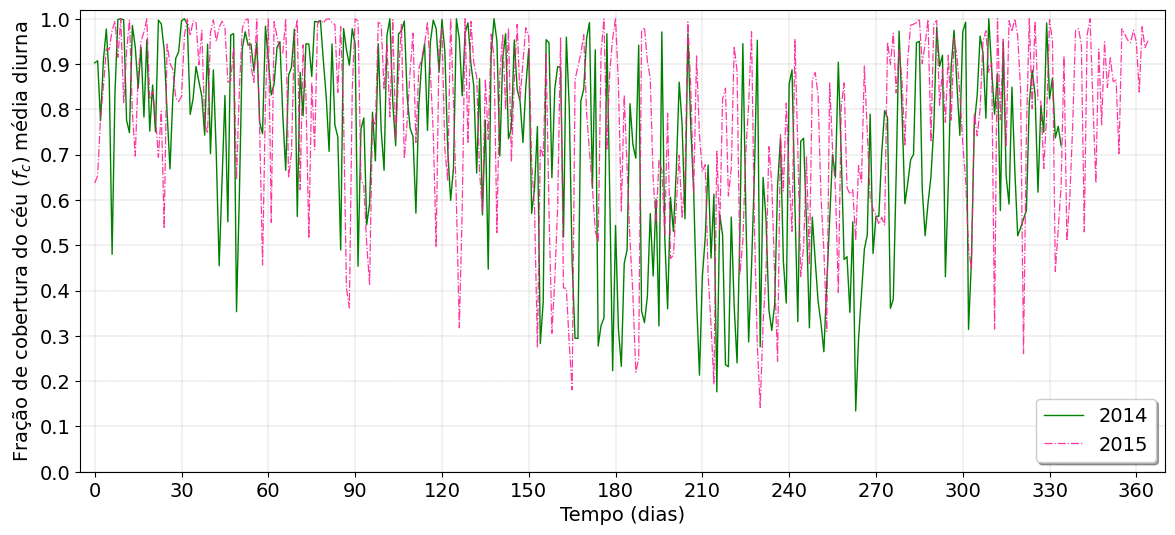

In [15]:
####################################################  Séries temporais (2014 e 2015) de CF diurna:
fig, ax = plt.subplots(figsize=(14, 6), facecolor='white')
tf = 12
cores = ['green', 'deeppink']
limitesx = [-5, 370]
limitesy = [0, 1.02]
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+2, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+2, color='black')
# ax.set_title("T3 site - GoAmazon", fontsize=tf+1.5)
ax.set_xlabel('Tempo (dias)', fontsize=tf+2)
ax.set_ylabel(r'Fração de cobertura do céu ($f_{c}$) média diurna', fontsize=tf+2)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(xlim=limitesx, ylim=limitesy, facecolor='white')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax.plot(np.arange(len(medias_cfs_diurnos[365:])), medias_cfs_diurnos[365:], color=cores[0], alpha=1,
        linewidth=1.0, linestyle='-', label='2014')
ax.plot(np.arange(len(medias_cfs_diarios[:365])), medias_cfs_diarios[:365], color=cores[1], alpha=0.85,
        linewidth=0.9, linestyle='-.', label='2015')
ax.legend(loc='lower right', frameon=True, fontsize=tf+2, ncol=1, fancybox=True, shadow=True)

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/CF_GoAmazon.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

### Médias e Medianas diárias e diurnas de IRF com e sem CF:

In [16]:
################################################################################# DIURNAS:
medias_diurnas_anuais_semcf = [np.nanmean(irfs_medias_diurnas_goamazon[:365]), 
                               np.nanmean(irfs_medias_diurnas_goamazon[365:])]
medianas_diurnas_anuais_semcf = [np.nanmedian(irfs_medias_diurnas_goamazon[:365]),
                                 np.nanmedian(irfs_medias_diurnas_goamazon[365:])]
medias_diurnas_anuais_comcf = [np.nanmean(irfs_medias_diurnas_goamazon_com_cfdiurna[:365]), 
                               np.nanmean(irfs_medias_diurnas_goamazon_com_cfdiurna[365:])]
medianas_diurnas_anuais_comcf = [np.nanmedian(irfs_medias_diurnas_goamazon_com_cfdiurna[:365]),
                                 np.nanmedian(irfs_medias_diurnas_goamazon_com_cfdiurna[365:])]

In [17]:
################################################################################# DIÁRIAS:
medias_diarias_anuais_semcf = [np.nanmean(irfs_medias_diarias_goamazon[:365]), 
                               np.nanmean(irfs_medias_diarias_goamazon[365:])]
medianas_diarias_anuais_semcf = [np.nanmedian(irfs_medias_diarias_goamazon[:365]),
                                 np.nanmedian(irfs_medias_diarias_goamazon[365:])]
medias_diarias_anuais_comcf = [np.nanmean(irfs_medias_diarias_goamazon_com_cfdiaria[:365]), 
                               np.nanmean(irfs_medias_diarias_goamazon_com_cfdiaria[365:])]
medianas_diarias_anuais_comcf = [np.nanmedian(irfs_medias_diarias_goamazon_com_cfdiaria[:365]),
                                 np.nanmedian(irfs_medias_diarias_goamazon_com_cfdiaria[365:])]

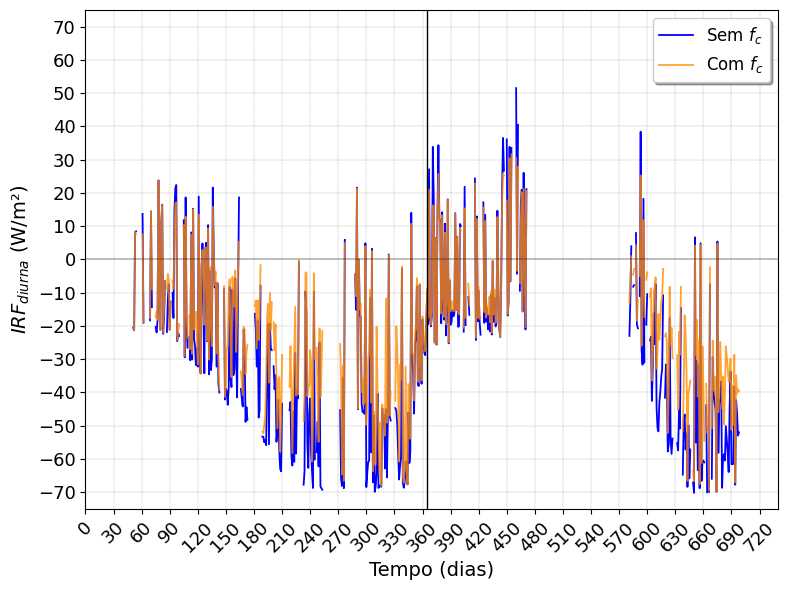

In [18]:
################################################################################# DIURNAS:
# fig, ax = plt.subplots(figsize=(6, 4), facecolor='white')
# tf = 10
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
tf = 13
cores = ['blue', 'darkorange']
limitesx = [0, 740]
limitesy = [-75.0, 75.0]
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='center', fontsize=tf, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
# ax.set_title("Diurnal IRF's for Stratiform Clouds at T3 site - GoAmazon", fontsize=tf+1)
ax.set_xlabel('Tempo (dias)', fontsize=tf+1)
# ax.set_ylabel(r'$\overline{IRF}_{diurna}$ (W/m²)', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(xlim=limitesx, ylim=limitesy, facecolor='white')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.plot(np.arange(len(irfs_medias_diurnas_goamazon)), irfs_medias_diurnas_goamazon,
        color=cores[0], alpha=1.0, linewidth=1.3, label=r'Sem $f_{c}$')
ax.plot(np.arange(len(irfs_medias_diurnas_goamazon_com_cfdiurna)), irfs_medias_diurnas_goamazon_com_cfdiurna,
        color=cores[1], alpha=0.8, linewidth=1.3, label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf-1, ncol=1, fancybox=True, shadow=True)

ax.vlines(x=365, ymin=limitesy[0], ymax=limitesy[1], colors='black', linewidth=1.00)
ax.hlines(y=0.0, xmin=limitesx[0], xmax=limitesx[1], colors='black', linewidth=0.30)

plt.tight_layout()
# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedia_diurna.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

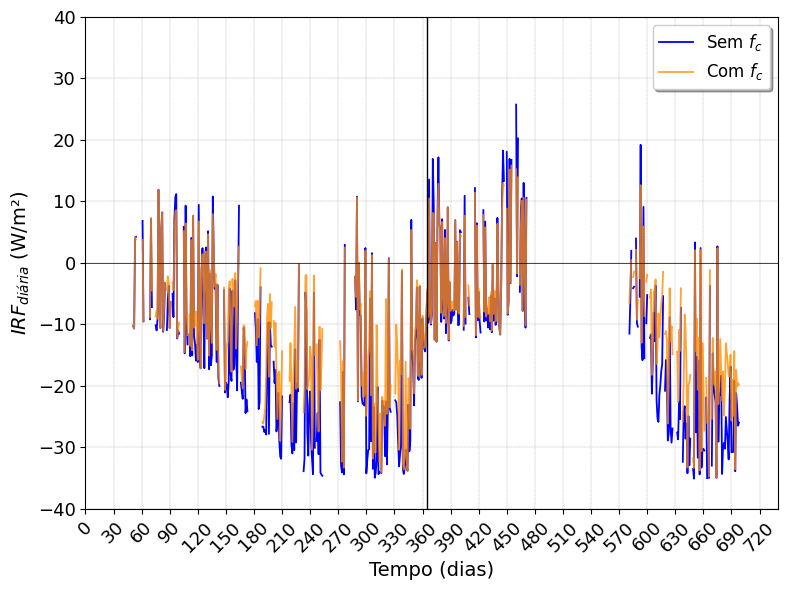

In [19]:
################################################################################# DIÁRIAS:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
tf = 13
cores = ['blue', 'darkorange']
limitesx = [0, 740]
# limitesy = [-75.0, 75.0]
limitesy = [-40.0, 40.0]
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='center', fontsize=tf, color='black')
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')
# ax.set_title("Daily IRF's for Stratiform Clouds at T3 site - GoAmazon", fontsize=tf+1)
ax.set_xlabel('Tempo (dias)', fontsize=tf+1)
# ax.set_ylabel(r'$\overline{IRF}_{diária}$ (W/m²)', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(xlim=limitesx, ylim=limitesy, facecolor='white')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

ax.plot(np.arange(len(irfs_medias_diarias_goamazon)), irfs_medias_diarias_goamazon,
        color=cores[0], alpha=1.0, linewidth=1.3, label='Sem $f_{c}$')
ax.plot(np.arange(len(irfs_medias_diarias_goamazon_com_cfdiaria)), irfs_medias_diarias_goamazon_com_cfdiaria,
        color=cores[1], alpha=0.8, linewidth=1.3, label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf-1, ncol=1, fancybox=True, shadow=True)

ax.vlines(x=365, ymin=limitesy[0], ymax=limitesy[1], colors='black', linewidth=1.00)
ax.hlines(y=0.0, xmin=limitesx[0], xmax=limitesx[1], colors='black', linewidth=0.50)

plt.tight_layout()
# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedia_diaria.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

### Boxplots com médias diárias e diurnas de IRF com e sem CF para cada uma das estações de 2014 e 2015:

In [23]:
seasons14 = [[10,91], [91,210], [210,278], [278,300], [300,346], [346,364]]

In [24]:
################################################################################# DIURNAS:
########################################## Sem CF:
estacoes_diurnas_comnan_semcf14 = [irfs_medias_diurnas_goamazon[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[5][0]:seasons14[5][1]]]
estacoes_diurnas_semnan_semcf14 = []
for lista_comnan in estacoes_diurnas_comnan_semcf14:
    estacoes_diurnas_semnan_semcf14.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
estacoes_diurnas_comnan_comcf14 = [irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[5][0]:seasons14[5][1]]]
estacoes_diurnas_semnan_comcf14 = []
for lista_comnan in estacoes_diurnas_comnan_comcf14:
    estacoes_diurnas_semnan_comcf14.append([x for x in lista_comnan if np.isnan(x) == False])

In [25]:
################################################################################# DIÁRIAS:
########################################## Sem CF:
estacoes_diarias_comnan_semcf14 = [irfs_medias_diarias_goamazon[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diarias_goamazon[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diarias_goamazon[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diarias_goamazon[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diarias_goamazon[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diarias_goamazon[seasons14[5][0]:seasons14[5][1]]]
estacoes_diarias_semnan_semcf14 = []
for lista_comnan in estacoes_diarias_comnan_semcf14:
    estacoes_diarias_semnan_semcf14.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
estacoes_diarias_comnan_comcf14 = [irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[5][0]:seasons14[5][1]]]
estacoes_diarias_semnan_comcf14 = []
for lista_comnan in estacoes_diarias_comnan_comcf14:
    estacoes_diarias_semnan_comcf14.append([x for x in lista_comnan if np.isnan(x) == False])

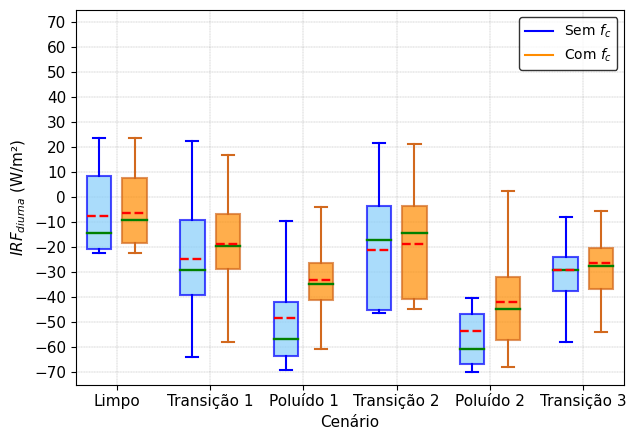

In [26]:
################################################################################# DIURNAS:
ticks = ['Limpo', 'Transição 1', 'Poluído 1', 'Transição 2', 'Poluído 2', 'Transição 3']
data_a = estacoes_diurnas_semnan_semcf14
data_b = estacoes_diurnas_semnan_comcf14

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("IRF's médias diurnas para os cenários de 2014", fontsize=tf+1)
ax.set_xlabel('Cenário', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diurnas_cenarios14.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

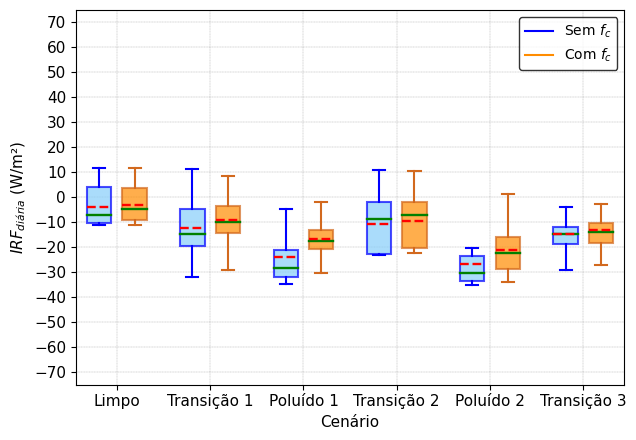

In [27]:
################################################################################# DIÁRIAS:
ticks = ['Limpo', 'Transição 1', 'Poluído 1', 'Transição 2', 'Poluído 2', 'Transição 3']
data_a = estacoes_diarias_semnan_semcf14
data_b = estacoes_diarias_semnan_comcf14

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("Mean daily IRF's for the 2014 seasons", fontsize=tf+1)
ax.set_xlabel('Cenário', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diarias_cenarios14.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

In [28]:
n = 365
seasons15 = [[0+n,211+n], [211+n,265+n], [265+n,336+n]]

In [29]:
################################################################################# DIURNAS:
########################################## Sem CF:
estacoes_diurnas_comnan_semcf15 = [irfs_medias_diurnas_goamazon[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diurnas_goamazon[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diurnas_goamazon[seasons15[2][0]:seasons15[2][1]]]
estacoes_diurnas_semnan_semcf15 = []
for lista_comnan in estacoes_diurnas_comnan_semcf15:
    estacoes_diurnas_semnan_semcf15.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
estacoes_diurnas_comnan_comcf15 = [irfs_medias_diurnas_goamazon_com_cfdiurna[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons15[2][0]:seasons15[2][1]]]
estacoes_diurnas_semnan_comcf15 = []
for lista_comnan in estacoes_diurnas_comnan_comcf15:
    estacoes_diurnas_semnan_comcf15.append([x for x in lista_comnan if np.isnan(x) == False])

In [30]:
################################################################################# DIÁRIAS:
########################################## Sem CF:
estacoes_diarias_comnan_semcf15 = [irfs_medias_diarias_goamazon[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diarias_goamazon[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diarias_goamazon[seasons15[2][0]:seasons15[2][1]]]
estacoes_diarias_semnan_semcf15 = []
for lista_comnan in estacoes_diarias_comnan_semcf15:
    estacoes_diarias_semnan_semcf15.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
estacoes_diarias_comnan_comcf15 = [irfs_medias_diarias_goamazon_com_cfdiaria[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons15[2][0]:seasons15[2][1]]]
estacoes_diarias_semnan_comcf15 = []
for lista_comnan in estacoes_diarias_comnan_comcf15:
    estacoes_diarias_semnan_comcf15.append([x for x in lista_comnan if np.isnan(x) == False])

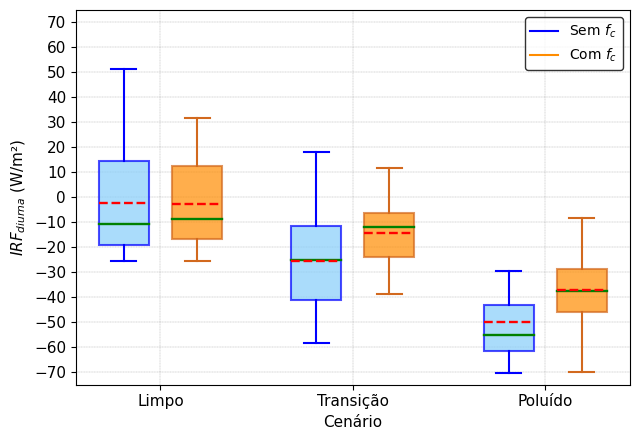

In [31]:
################################################################################# DIURNAS:
ticks = ['Limpo', 'Transição', 'Poluído']
data_a = estacoes_diurnas_semnan_semcf15
data_b = estacoes_diurnas_semnan_comcf15

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
# cores = ['violet', 'blueviolet', 'lightgreen', 'limegreen']
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("Mean diurnal IRF's for the 2015 seasons", fontsize=tf+1)
ax.set_xlabel('Cenário', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diurnas_cenarios15.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

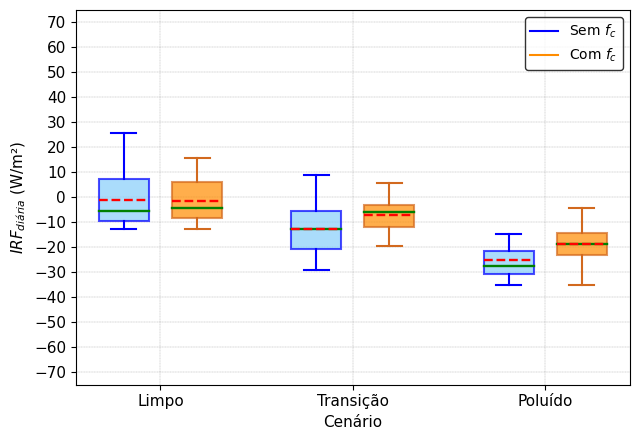

In [32]:
################################################################################# DIÁRIAS:
ticks = ['Limpo', 'Transição', 'Poluído']
data_a = estacoes_diarias_semnan_semcf15
data_b = estacoes_diarias_semnan_comcf15

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
# cores = ['violet', 'blueviolet', 'lightgreen', 'limegreen']
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("Mean daily IRF's for the 2015 seasons", fontsize=tf+1)
ax.set_xlabel('Cenário', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diarias_cenarios15.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

### Boxplots com médias diárias e diurnas de IRF com e sem CF para cada uma das SAZONALIDADES (CHUVA) de 2014 e 2015:

In [33]:
sazonas14 = [[0,150], [151,211], [212,272], [273,364]]

In [34]:
################################################################################# DIURNAS:
########################################## Sem CF:
sazonas_diurnas_comnan_semcf14 = [irfs_medias_diurnas_goamazon[sazonas14[0][0]:sazonas14[0][1]],
                                  irfs_medias_diurnas_goamazon[sazonas14[1][0]:sazonas14[1][1]],
                                  irfs_medias_diurnas_goamazon[sazonas14[2][0]:sazonas14[2][1]],
                                  irfs_medias_diurnas_goamazon[sazonas14[3][0]:sazonas14[3][1]]]
sazonas_diurnas_comnan_semcf14_final = [list(sazonas_diurnas_comnan_semcf14[0])+list(sazonas_diurnas_comnan_semcf14[3]),
                                        sazonas_diurnas_comnan_semcf14[1], sazonas_diurnas_comnan_semcf14[2]]
sazonas_diurnas_semnan_semcf14 = []
for lista_comnan in sazonas_diurnas_comnan_semcf14_final:
    sazonas_diurnas_semnan_semcf14.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
sazonas_diurnas_comnan_comcf14 = [irfs_medias_diurnas_goamazon_com_cfdiurna[sazonas14[0][0]:sazonas14[0][1]],
                                  irfs_medias_diurnas_goamazon_com_cfdiurna[sazonas14[1][0]:sazonas14[1][1]],
                                  irfs_medias_diurnas_goamazon_com_cfdiurna[sazonas14[2][0]:sazonas14[2][1]],
                                  irfs_medias_diurnas_goamazon_com_cfdiurna[sazonas14[3][0]:sazonas14[3][1]]]
sazonas_diurnas_comnan_comcf14_final = [list(sazonas_diurnas_comnan_comcf14[0])+list(sazonas_diurnas_comnan_comcf14[3]), 
                                        sazonas_diurnas_comnan_comcf14[1], sazonas_diurnas_comnan_comcf14[2]]
sazonas_diurnas_semnan_comcf14 = []
for lista_comnan in sazonas_diurnas_comnan_comcf14_final:
    sazonas_diurnas_semnan_comcf14.append([x for x in lista_comnan if np.isnan(x) == False])

In [35]:
################################################################################# DIÁRIAS:
########################################## Sem CF:
sazonas_diarias_comnan_semcf14 = [irfs_medias_diarias_goamazon[sazonas14[0][0]:sazonas14[0][1]],
                                  irfs_medias_diarias_goamazon[sazonas14[1][0]:sazonas14[1][1]],
                                  irfs_medias_diarias_goamazon[sazonas14[2][0]:sazonas14[2][1]],
                                  irfs_medias_diarias_goamazon[sazonas14[3][0]:sazonas14[3][1]]]
sazonas_diarias_comnan_semcf14_final = [list(sazonas_diarias_comnan_semcf14[0])+list(sazonas_diarias_comnan_semcf14[3]),
                                        sazonas_diarias_comnan_semcf14[1], sazonas_diarias_comnan_semcf14[2]]
sazonas_diarias_semnan_semcf14 = []
for lista_comnan in sazonas_diarias_comnan_semcf14_final:
    sazonas_diarias_semnan_semcf14.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
sazonas_diarias_comnan_comcf14 = [irfs_medias_diarias_goamazon_com_cfdiaria[sazonas14[0][0]:sazonas14[0][1]],
                                  irfs_medias_diarias_goamazon_com_cfdiaria[sazonas14[1][0]:sazonas14[1][1]],
                                  irfs_medias_diarias_goamazon_com_cfdiaria[sazonas14[2][0]:sazonas14[2][1]],
                                  irfs_medias_diarias_goamazon_com_cfdiaria[sazonas14[3][0]:sazonas14[3][1]]]
sazonas_diarias_comnan_comcf14_final = [list(sazonas_diarias_comnan_comcf14[0])+list(sazonas_diarias_comnan_comcf14[3]), 
                                        sazonas_diarias_comnan_comcf14[1], sazonas_diarias_comnan_comcf14[2]]
sazonas_diarias_semnan_comcf14 = []
for lista_comnan in sazonas_diarias_comnan_comcf14_final:
    sazonas_diarias_semnan_comcf14.append([x for x in lista_comnan if np.isnan(x) == False])

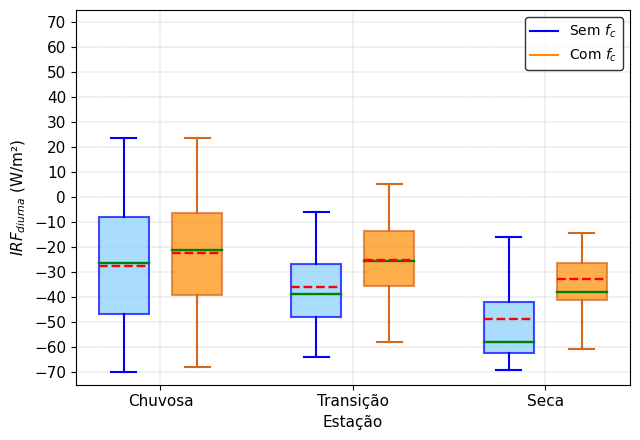

In [36]:
################################################################################# DIURNAS:
ticks = ['Chuvosa', 'Transição', 'Seca']
data_a = sazonas_diurnas_semnan_semcf14
data_b = sazonas_diurnas_semnan_comcf14

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("IRF's médias diurnas para os cenários de 2014", fontsize=tf+1)
ax.set_xlabel('Estação', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diurnas_sazonalidades14.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

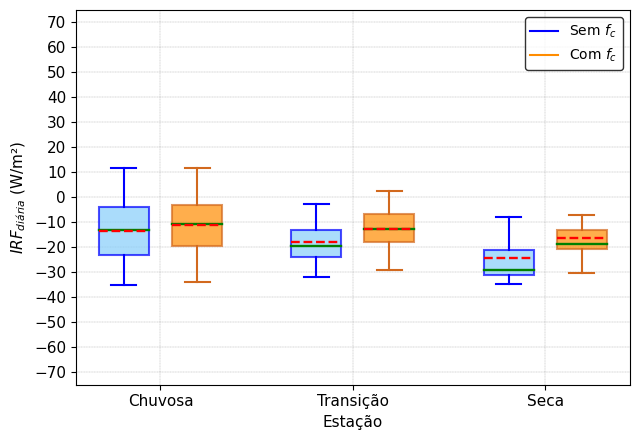

In [37]:
################################################################################# DIÁRIAS:
ticks = ['Chuvosa', 'Transição', 'Seca']
data_a = sazonas_diarias_semnan_semcf14
data_b = sazonas_diarias_semnan_comcf14

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("IRF's médias diurnas para os cenários de 2014", fontsize=tf+1)
ax.set_xlabel('Estação', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diarias_sazonalidades14.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

In [38]:
n = 365
sazonas15 = [[0+n,180+n], [181+n,211+n], [212+n,364+n]]

In [39]:
################################################################################# DIURNAS:
########################################## Sem CF:
sazonas_diurnas_comnan_semcf15 = [irfs_medias_diurnas_goamazon[sazonas15[0][0]:sazonas15[0][1]],
                                  irfs_medias_diurnas_goamazon[sazonas15[1][0]:sazonas15[1][1]],
                                  irfs_medias_diurnas_goamazon[sazonas15[2][0]:sazonas15[2][1]]]
sazonas_diurnas_semnan_semcf15 = []
for lista_comnan in sazonas_diurnas_comnan_semcf15:
    sazonas_diurnas_semnan_semcf15.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
sazonas_diurnas_comnan_comcf15 = [irfs_medias_diurnas_goamazon_com_cfdiurna[sazonas15[0][0]:sazonas15[0][1]],
                                  irfs_medias_diurnas_goamazon_com_cfdiurna[sazonas15[1][0]:sazonas15[1][1]],
                                  irfs_medias_diurnas_goamazon_com_cfdiurna[sazonas15[2][0]:sazonas15[2][1]]]
sazonas_diurnas_semnan_comcf15 = []
for lista_comnan in sazonas_diurnas_comnan_comcf15:
    sazonas_diurnas_semnan_comcf15.append([x for x in lista_comnan if np.isnan(x) == False])

In [40]:
################################################################################# DIÁRIAS:
########################################## Sem CF:
sazonas_diarias_comnan_semcf15 = [irfs_medias_diarias_goamazon[sazonas15[0][0]:sazonas15[0][1]],
                                  irfs_medias_diarias_goamazon[sazonas15[1][0]:sazonas15[1][1]],
                                  irfs_medias_diarias_goamazon[sazonas15[2][0]:sazonas15[2][1]]]
sazonas_diarias_semnan_semcf15 = []
for lista_comnan in sazonas_diarias_comnan_semcf15:
    sazonas_diarias_semnan_semcf15.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
sazonas_diarias_comnan_comcf15 = [irfs_medias_diarias_goamazon_com_cfdiaria[sazonas15[0][0]:sazonas15[0][1]],
                                  irfs_medias_diarias_goamazon_com_cfdiaria[sazonas15[1][0]:sazonas15[1][1]],
                                  irfs_medias_diarias_goamazon_com_cfdiaria[sazonas15[2][0]:sazonas15[2][1]]]
sazonas_diarias_semnan_comcf15 = []
for lista_comnan in sazonas_diarias_comnan_comcf15:
    sazonas_diarias_semnan_comcf15.append([x for x in lista_comnan if np.isnan(x) == False])

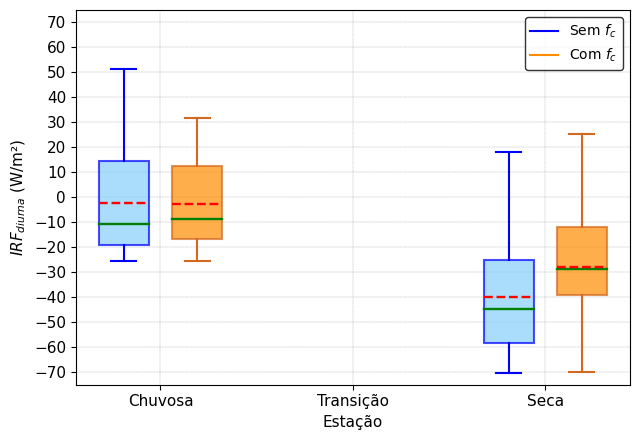

In [41]:
################################################################################# DIURNAS:
ticks = ['Chuvosa', 'Transição', 'Seca']
data_a = sazonas_diurnas_semnan_semcf15
data_b = sazonas_diurnas_semnan_comcf15

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("IRF's médias diurnas para os cenários de 2014", fontsize=tf+1)
ax.set_xlabel('Estação', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diurnas_sazonalidades15.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

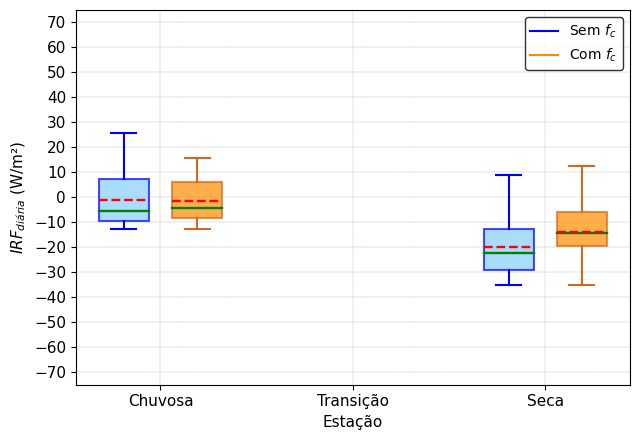

In [42]:
################################################################################# DIURNAS:
ticks = ['Chuvosa', 'Transição', 'Seca']
data_a = sazonas_diarias_semnan_semcf15
data_b = sazonas_diarias_semnan_comcf15

fig, ax = plt.subplots(figsize=(6.5, 4.5), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("IRF's médias diurnas para os cenários de 2014", fontsize=tf+1)
ax.set_xlabel('Estação', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diarias_sazonalidades15.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

### Boxplots com médias diárias e diurnas de IRF com e sem CF para cada um dos trimestres de 2014 e 2015:

In [43]:
trims14 = [[0,90], [90,181], [181,273], [273,365]]

In [44]:
################################################################################# DIURNAS:
########################################## Sem CF:
trims_diurnas_comnan_semcf14 = [irfs_medias_diurnas_goamazon[trims14[0][0]:trims14[0][1]],
                                irfs_medias_diurnas_goamazon[trims14[1][0]:trims14[1][1]],
                                irfs_medias_diurnas_goamazon[trims14[2][0]:trims14[2][1]],
                                irfs_medias_diurnas_goamazon[trims14[3][0]:trims14[3][1]]]
trims_diurnas_semnan_semcf14 = []
for lista_comnan in trims_diurnas_comnan_semcf14:
    trims_diurnas_semnan_semcf14.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
trims_diurnas_comnan_comcf14 = [irfs_medias_diurnas_goamazon_com_cfdiurna[trims14[0][0]:trims14[0][1]],
                                irfs_medias_diurnas_goamazon_com_cfdiurna[trims14[1][0]:trims14[1][1]],
                                irfs_medias_diurnas_goamazon_com_cfdiurna[trims14[2][0]:trims14[2][1]],
                                irfs_medias_diurnas_goamazon_com_cfdiurna[trims14[3][0]:trims14[3][1]]]
trims_diurnas_semnan_comcf14 = []
for lista_comnan in trims_diurnas_comnan_comcf14:
    trims_diurnas_semnan_comcf14.append([x for x in lista_comnan if np.isnan(x) == False])

In [45]:
################################################################################# DIÁRIAS:
########################################## Sem CF:
trims_diarias_comnan_semcf14 = [irfs_medias_diarias_goamazon[trims14[0][0]:trims14[0][1]],
                                irfs_medias_diarias_goamazon[trims14[1][0]:trims14[1][1]],
                                irfs_medias_diarias_goamazon[trims14[2][0]:trims14[2][1]],
                                irfs_medias_diarias_goamazon[trims14[3][0]:trims14[3][1]]]
trims_diarias_semnan_semcf14 = []
for lista_comnan in trims_diarias_comnan_semcf14:
    trims_diarias_semnan_semcf14.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
trims_diarias_comnan_comcf14 = [irfs_medias_diarias_goamazon_com_cfdiaria[trims14[0][0]:trims14[0][1]],
                                irfs_medias_diarias_goamazon_com_cfdiaria[trims14[1][0]:trims14[1][1]],
                                irfs_medias_diarias_goamazon_com_cfdiaria[trims14[2][0]:trims14[2][1]],
                                irfs_medias_diarias_goamazon_com_cfdiaria[trims14[3][0]:trims14[3][1]]]
trims_diarias_semnan_comcf14 = []
for lista_comnan in trims_diarias_comnan_comcf14:
    trims_diarias_semnan_comcf14.append([x for x in lista_comnan if np.isnan(x) == False])

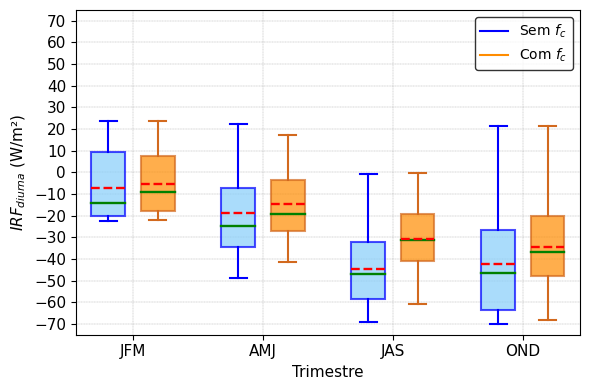

In [46]:
################################################################################# DIURNAS:
ticks = ['JFM', 'AMJ', 'JAS', 'OND']
data_a = trims_diurnas_semnan_semcf14
data_b = trims_diurnas_semnan_comcf14

fig, ax = plt.subplots(figsize=(6, 4), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("Mean diurnal IRF's for the 2014 quarters", fontsize=tf+1)
ax.set_xlabel('Trimestre', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diurnas_trimestres14.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

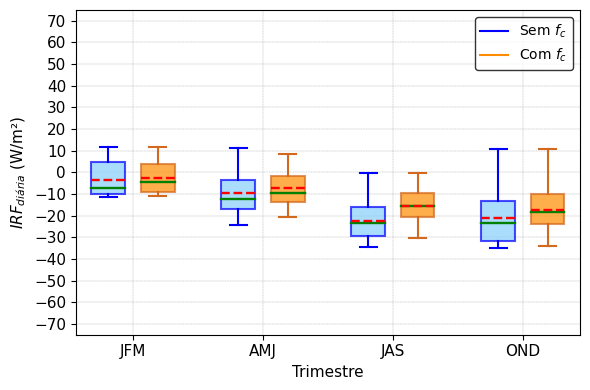

In [47]:
################################################################################# DIÁRIAS:
ticks = ['JFM', 'AMJ', 'JAS', 'OND']
data_a = trims_diarias_semnan_semcf14
data_b = trims_diarias_semnan_comcf14

fig, ax = plt.subplots(figsize=(6, 4), facecolor='white')
tf = 10
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("Mean daily IRF's for the 2014 quarters", fontsize=tf+1)
ax.set_xlabel('Trimestre', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diarias_trimestres14.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

In [48]:
n = 365
trims15 = [[0+n,90+n], [90+n,181+n], [181+n,273+n], [273+n,365+n]]

In [49]:
################################################################################# DIURNAS:
########################################## Sem CF:
trims_diurnas_comnan_semcf15 = [irfs_medias_diurnas_goamazon[trims15[0][0]:trims15[0][1]],
                                irfs_medias_diurnas_goamazon[trims15[1][0]:trims15[1][1]],
                                irfs_medias_diurnas_goamazon[trims15[2][0]:trims15[2][1]],
                                irfs_medias_diurnas_goamazon[trims15[3][0]:trims15[3][1]]]
trims_diurnas_semnan_semcf15 = []
for lista_comnan in trims_diurnas_comnan_semcf15:
    trims_diurnas_semnan_semcf15.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
trims_diurnas_comnan_comcf15 = [irfs_medias_diurnas_goamazon_com_cfdiurna[trims15[0][0]:trims15[0][1]],
                                irfs_medias_diurnas_goamazon_com_cfdiurna[trims15[1][0]:trims15[1][1]],
                                irfs_medias_diurnas_goamazon_com_cfdiurna[trims15[2][0]:trims15[2][1]],
                                irfs_medias_diurnas_goamazon_com_cfdiurna[trims15[3][0]:trims15[3][1]]]
trims_diurnas_semnan_comcf15 = []
for lista_comnan in trims_diurnas_comnan_comcf15:
    trims_diurnas_semnan_comcf15.append([x for x in lista_comnan if np.isnan(x) == False])

In [50]:
################################################################################# DIÁRIAS:
########################################## Sem CF:
trims_diarias_comnan_semcf15 = [irfs_medias_diarias_goamazon[trims15[0][0]:trims15[0][1]],
                                irfs_medias_diarias_goamazon[trims15[1][0]:trims15[1][1]],
                                irfs_medias_diarias_goamazon[trims15[2][0]:trims15[2][1]],
                                irfs_medias_diarias_goamazon[trims15[3][0]:trims15[3][1]]]
trims_diarias_semnan_semcf15 = []
for lista_comnan in trims_diarias_comnan_semcf15:
    trims_diarias_semnan_semcf15.append([x for x in lista_comnan if np.isnan(x) == False])
########################################## Com CF:
trims_diarias_comnan_comcf15 = [irfs_medias_diarias_goamazon_com_cfdiaria[trims15[0][0]:trims15[0][1]],
                                irfs_medias_diarias_goamazon_com_cfdiaria[trims15[1][0]:trims15[1][1]],
                                irfs_medias_diarias_goamazon_com_cfdiaria[trims15[2][0]:trims15[2][1]],
                                irfs_medias_diarias_goamazon_com_cfdiaria[trims15[3][0]:trims15[3][1]]]
trims_diarias_semnan_comcf15 = []
for lista_comnan in trims_diarias_comnan_comcf15:
    trims_diarias_semnan_comcf15.append([x for x in lista_comnan if np.isnan(x) == False])

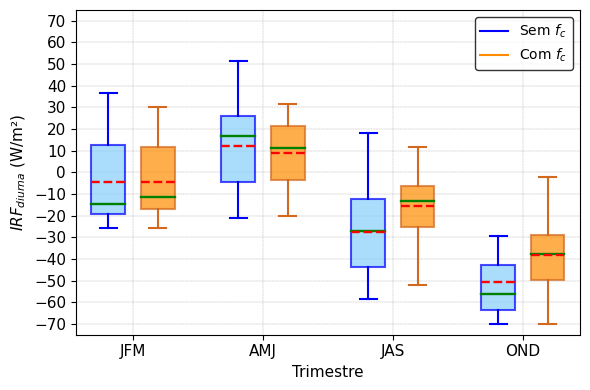

In [51]:
################################################################################# DIURNAS:
ticks = ['JFM', 'AMJ', 'JAS', 'OND']
data_a = trims_diurnas_semnan_semcf15
data_b = trims_diurnas_semnan_comcf15

fig, ax = plt.subplots(figsize=(6, 4), facecolor='white')
tf = 10
# cores = ['violet', 'blueviolet', 'lightgreen', 'limegreen']
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("Mean diurnal IRF's for the 2015 quarters", fontsize=tf+1)
ax.set_xlabel('Trimestre', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diurnas_trimestres15.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

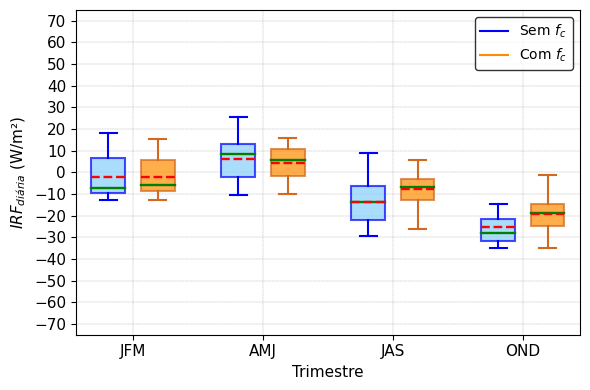

In [52]:
################################################################################# DIÁRIAS:
ticks = ['JFM', 'AMJ', 'JAS', 'OND']
data_a = trims_diarias_semnan_semcf15
data_b = trims_diarias_semnan_comcf15

fig, ax = plt.subplots(figsize=(6, 4), facecolor='white')
tf = 10
# cores = ['violet', 'blueviolet', 'lightgreen', 'limegreen']
cores = ['lightskyblue', 'blue', 'darkorange', 'chocolate']
limitesy = [-75.0, 75.0]
plt.setp(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf+1, color='black')
plt.setp(ax.get_xticklabels(), rotation=0, horizontalalignment='center', fontsize=tf+1, color='black')
# ax.set_title("Mean daily IRF's for the 2015 quarters", fontsize=tf+1)
ax.set_xlabel('Trimestre', fontsize=tf+1)
ax.set_ylabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf+1)
ax.grid(axis='both', linestyle='--', linewidth=0.22, color='grey')
ax.set(ylim=limitesy, facecolor='white')
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

bplot_a = ax.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[1], linewidth=1.5),
                     capprops=dict(color=cores[1], linewidth=1.5),
                     boxprops=dict(color=cores[1], facecolor=cores[0], linewidth=1.5, alpha=0.7))
    
bplot_b = ax.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.38, sym='', widths=0.52, 
                     patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                     meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                     medianprops=dict(color='green', linewidth=1.7),
                     whiskerprops=dict(color=cores[3], linewidth=1.5),
                     capprops=dict(color=cores[3], linewidth=1.5),
                     boxprops=dict(color=cores[3], facecolor=cores[2], linewidth=1.5, alpha=0.7))

ax.plot([], c=cores[1], label='Sem $f_{c}$')
ax.plot([], c=cores[2], label='Com $f_{c}$')
ax.legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=False, edgecolor='black')
plt.xticks(range(0, len(ticks)*2, 2), ticks)
plt.tight_layout()

# plt.savefig('/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/IRFmedias_diarias_trimestres15.png',
#                     dpi=400, bbox_inches='tight', facecolor='white')

In [53]:
##########################################################################################

In [54]:
###### Para cada cenário de 2014 fazendo uma lista onde os NAN's são substituídos pela média daquele cenário:
seasons14 = [[0,91], [91,210], [210,278], [278,300], [300,346], [346,365]]
################################################################################# DIURNAS:
########################################## Sem CF:
estacoes_diurnas_comnan_semcf14 = [irfs_medias_diurnas_goamazon[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diurnas_goamazon[seasons14[5][0]:seasons14[5][1]]]
########################################## Com CF:
estacoes_diurnas_comnan_comcf14 = [irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons14[5][0]:seasons14[5][1]]]
################################################################################# DIÁRIAS:
########################################## Sem CF:
estacoes_diarias_comnan_semcf14 = [irfs_medias_diarias_goamazon[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diarias_goamazon[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diarias_goamazon[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diarias_goamazon[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diarias_goamazon[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diarias_goamazon[seasons14[5][0]:seasons14[5][1]]]
########################################## Com CF:
estacoes_diarias_comnan_comcf14 = [irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[0][0]:seasons14[0][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[1][0]:seasons14[1][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[2][0]:seasons14[2][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[3][0]:seasons14[3][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[4][0]:seasons14[4][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons14[5][0]:seasons14[5][1]]]
### DIURNAS:
listasjuntas = []
for i in range(len(estacoes_diurnas_comnan_semcf14)):
    lista = list(estacoes_diurnas_comnan_semcf14[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diurnas_semcf14 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]+listasjuntas[3]+listasjuntas[4]+ \
                       listasjuntas[5]

listasjuntas = []
for i in range(len(estacoes_diurnas_comnan_comcf14)):
    lista = list(estacoes_diurnas_comnan_comcf14[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diurnas_comcf14 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]+listasjuntas[3]+listasjuntas[4]+ \
                       listasjuntas[5]
### DIÁRIAS:
listasjuntas = []
for i in range(len(estacoes_diarias_comnan_semcf14)):
    lista = list(estacoes_diarias_comnan_semcf14[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diarias_semcf14 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]+listasjuntas[3]+listasjuntas[4]+ \
                       listasjuntas[5]

listasjuntas = []
for i in range(len(estacoes_diarias_comnan_comcf14)):
    lista = list(estacoes_diarias_comnan_comcf14[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diarias_comcf14 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]+listasjuntas[3]+listasjuntas[4]+ \
                       listasjuntas[5]

In [55]:
###### Para cada cenário de 2015 fazendo uma lista onde os NAN's são substituídos pela média daquele cenário:
n = 365
seasons15 = [[0+n,211+n], [211+n,265+n], [265+n,365+n]]
################################################################################# DIURNAS:
########################################## Sem CF:
estacoes_diurnas_comnan_semcf15 = [irfs_medias_diurnas_goamazon[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diurnas_goamazon[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diurnas_goamazon[seasons15[2][0]:seasons15[2][1]]]
########################################## Com CF:
estacoes_diurnas_comnan_comcf15 = [irfs_medias_diurnas_goamazon_com_cfdiurna[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diurnas_goamazon_com_cfdiurna[seasons15[2][0]:seasons15[2][1]]]
################################################################################# DIÁRIAS:
########################################## Sem CF:
estacoes_diarias_comnan_semcf15 = [irfs_medias_diarias_goamazon[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diarias_goamazon[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diarias_goamazon[seasons15[2][0]:seasons15[2][1]]]
########################################## Com CF:
estacoes_diarias_comnan_comcf15 = [irfs_medias_diarias_goamazon_com_cfdiaria[seasons15[0][0]:seasons15[0][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons15[1][0]:seasons15[1][1]],
                                   irfs_medias_diarias_goamazon_com_cfdiaria[seasons15[2][0]:seasons15[2][1]]]
### DIURNAS:
listasjuntas = []
for i in range(len(estacoes_diurnas_comnan_semcf15)):
    lista = list(estacoes_diurnas_comnan_semcf15[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diurnas_semcf15 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]

listasjuntas = []
for i in range(len(estacoes_diurnas_comnan_comcf15)):
    lista = list(estacoes_diurnas_comnan_comcf15[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diurnas_comcf15 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]
### DIÁRIAS:
listasjuntas = []
for i in range(len(estacoes_diarias_comnan_semcf15)):
    lista = list(estacoes_diarias_comnan_semcf15[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diarias_semcf15 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]

listasjuntas = []
for i in range(len(estacoes_diarias_comnan_comcf15)):
    lista = list(estacoes_diarias_comnan_comcf15[i])
    for index, v in enumerate(lista):
        if np.isnan(v) == True:
            lista[index] = np.nanmean(lista)
    listasjuntas.append(lista)
irfs_diarias_comcf15 = listasjuntas[0]+listasjuntas[1]+listasjuntas[2]

### Histogramas, boxplots e médias diárias e diurnas de IRF com e sem CF para cada ano (2014 e 2015):

In [56]:
# ################################################################################# DIURNAS:
# irfs_diurnas_semnan_semcf_14 = [x for x in irfs_medias_diurnas_goamazon[:365] if np.isnan(x) == False]
# irfs_diurnas_semnan_semcf_15 = [x for x in irfs_medias_diurnas_goamazon[365:] if np.isnan(x) == False]
# irfs_diurnas_semnan_comcf_14 = [x for x in irfs_medias_diurnas_goamazon_com_cfdiurna[:365] if np.isnan(x)==False]
# irfs_diurnas_semnan_comcf_15 = [x for x in irfs_medias_diurnas_goamazon_com_cfdiurna[365:] if np.isnan(x)==False]

# ################################################################################# DIÁRIAS:
# irfs_diarias_semnan_semcf_14 = [x for x in irfs_medias_diarias_goamazon[:365] if np.isnan(x) == False]
# irfs_diarias_semnan_semcf_15 = [x for x in irfs_medias_diarias_goamazon[365:] if np.isnan(x) == False]
# irfs_diarias_semnan_comcf_14 = [x for x in irfs_medias_diarias_goamazon_com_cfdiaria[:365] if np.isnan(x)==False]
# irfs_diarias_semnan_comcf_15 = [x for x in irfs_medias_diarias_goamazon_com_cfdiaria[365:] if np.isnan(x)==False]

In [58]:
### Função para plotar histogramas e boxplots (na horizontal, acima do histograma) anuais: 
def histogramas_boxplots_anuais(tipo, dados1, dados2, cores, status):
    stats1 = [np.nanmean(dados1), np.nanmedian(dados1), np.percentile(dados1, 25), np.percentile(dados1, 75)]
    stats2 = [np.nanmean(dados2), np.nanmedian(dados2), np.percentile(dados2, 25), np.percentile(dados2, 75)]
    tf = 12
    ax1 = plt.axes([.1, 0.85, .8, .22])
    ax2 = plt.axes([.1, .1, .8, .8])
    ax3 = plt.axes([1.05, 0.85, .8, .22])
    ax4 = plt.axes([1.05, 0.1, .8, .8])
    axes = [ax1, ax2, ax3, ax4]
    for i in range(len(axes)):
        if i==1 or i==3:
            axes[i].set_ylim([0.0, 0.65])
            axes[i].set_xlim([-75.0, 75.0])
        else:
            axes[i].set_xlim([-75.0, 75.0])
    ####################### Boxplot 14:
    bplots = axes[0].boxplot(dados1, vert=0, patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                             meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                             medianprops=dict(color='green', linewidth=1.7),
                             whiskerprops=dict(color=cores[1], linewidth=1.5),
                             capprops=dict(color=cores[1], linewidth=1.5))
    axes[0].axis('off')
    for i, bplot in enumerate(bplots['boxes']):
        bplot.set(color=cores[1], linewidth=1.5, alpha=1)
        bplot.set(facecolor=cores[0], alpha=0.6)
    axes[0].set_title('2014', y=0.9, pad=-10, fontsize=tf)
    ####################### Histograma 14:
    axes[1].grid(True, axis='y', zorder=0, linestyle=':', color='dimgray')
    if tipo == 'diurno':
        axes[1].set_xlabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf)
    elif tipo == 'diario':
        axes[1].set_xlabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf)
    axes[1].set_ylabel('Frequência relativa', fontsize=tf)
    axes[1].tick_params(labelsize=tf)
    sns.histplot(data=dados1, ax=axes[1], color=cores[0], stat='probability', edgecolor=cores[1],
                 binwidth=10, linewidth=1.2, element="step", binrange=[-70, 70], kde=False, alpha=0.6)
    axes[1].yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    axes[1].xaxis.set_major_locator(ticker.MultipleLocator(10))
    if stats1[0] > stats1[1]:
        axes[1].axvline(x=stats1[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.2f}'.format(stats1[2]))
        axes[1].axvline(x=stats1[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.2f}'.format(stats1[1]))
        axes[1].axvline(x=stats1[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.2f}'.format(stats1[0]))
        axes[1].axvline(x=stats1[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.2f}'.format(stats1[3]))
    elif stats1[0] < stats1[1]:
        axes[1].axvline(x=stats1[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.2f}'.format(stats1[2]))
        axes[1].axvline(x=stats1[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.2f}'.format(stats1[0]))
        axes[1].axvline(x=stats1[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.2f}'.format(stats1[1]))
        axes[1].axvline(x=stats1[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.2f}'.format(stats1[3]))
    axes[1].legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=True)
    plt.setp(axes[1].get_xticklabels(), rotation=45, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[1].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')

    ####################### Boxplot 15:
    bplots = axes[2].boxplot(dados2, vert=0, patch_artist=True, showfliers=False, meanline=True, showmeans=True,
                             meanprops=dict(color='red', linestyle='--', linewidth=1.7),
                             medianprops=dict(color='green', linewidth=1.7),
                             whiskerprops=dict(color=cores[3], linewidth=1.5),
                             capprops=dict(color=cores[3], linewidth=1.5))
    axes[2].axis('off')
    for i, bplot in enumerate(bplots['boxes']):
        bplot.set(color=cores[3], linewidth=1.5, alpha=1)
        bplot.set(facecolor=cores[2], alpha=0.6)
    axes[2].set_title('2015', y=0.9, pad=-10, fontsize=tf)
    ####################### Histograma 15:
    axes[3].grid(True, axis='y', zorder=0, linestyle=':', color='dimgray')
    axes[3].set_xlabel(r'$IRF_{day}$ (W/m²)', fontsize=tf)
    if tipo == 'diurno':
        axes[3].set_xlabel(r'$IRF_{diurna}$ (W/m²)', fontsize=tf)
    elif tipo == 'diario':
        axes[3].set_xlabel(r'$IRF_{diária}$ (W/m²)', fontsize=tf)
    axes[3].set_ylabel('Frequência relativa', fontsize=tf)
    axes[3].tick_params(labelsize=tf)
    sns.histplot(data=dados2, ax=axes[3], color=cores[2], stat='probability', edgecolor=cores[3],
                 binwidth=10, linewidth=1.2, element="step", binrange=[-70, 70], kde=False, alpha=0.6)
    axes[3].yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    axes[3].xaxis.set_major_locator(ticker.MultipleLocator(10))
    if stats2[0] > stats2[1]:
        axes[3].axvline(x=stats2[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.2f}'.format(stats2[2]))
        axes[3].axvline(x=stats2[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.2f}'.format(stats2[1]))
        axes[3].axvline(x=stats2[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.2f}'.format(stats2[0]))
        axes[3].axvline(x=stats2[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.2f}'.format(stats2[3]))
    elif stats2[0] < stats2[1]:
        axes[3].axvline(x=stats2[2],color='gray',  linestyle='-.',lw=1.7,label='25%   = {0:.2f}'.format(stats2[2]))
        axes[3].axvline(x=stats2[0],color='red',   linestyle='--',lw=1.7,label='Média = {0:.2f}'.format(stats2[0]))
        axes[3].axvline(x=stats2[1],color='green', linestyle='-',lw=1.7,label='50%   = {0:.2f}'.format(stats2[1]))
        axes[3].axvline(x=stats2[3],color='gray',  linestyle='-.',lw=1.7,label='75%   = {0:.2f}'.format(stats2[3]))
    axes[3].legend(loc='upper right', frameon=True, fontsize=tf, ncol=1, fancybox=True, shadow=True)
    plt.setp(axes[3].get_xticklabels(), rotation=45, horizontalalignment='center', fontsize=tf, color='black')
    plt.setp(axes[3].get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=tf, color='black')

    ####################### Título:
#     if status == 'sem':
#         axes[0].text(x=71.5, y=1.55, s='Sem $f_{c}$', fontsize=tf+1)
#     elif status == 'com':
#         axes[0].text(x=71.5, y=1.55, s='Com $f_{c}$', fontsize=tf+1)
    plt.tight_layout()
    
    ##################################### Salvando as figuras #################################################
#     ppp = '/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/'
#     if status == 'sem':
#         if tipo == 'diurno':
#             plt.savefig(ppp+'IRFmedias_diurnas_anos_semcf.png', dpi=400, bbox_inches='tight', facecolor='white')
#         elif tipo == 'diario':
#             plt.savefig(ppp+'IRFmedias_diarias_anos_semcf.png', dpi=400, bbox_inches='tight', facecolor='white')
#     elif status == 'com':
#         if tipo == 'diurno':
#             plt.savefig(ppp+'IRFmedias_diurnas_anos_comcf.png', dpi=400, bbox_inches='tight', facecolor='white')
#         elif tipo == 'diario':
#             plt.savefig(ppp+'IRFmedias_diarias_anos_comcf.png', dpi=400, bbox_inches='tight', facecolor='white')
    ###########################################################################################################
#     plt.show()

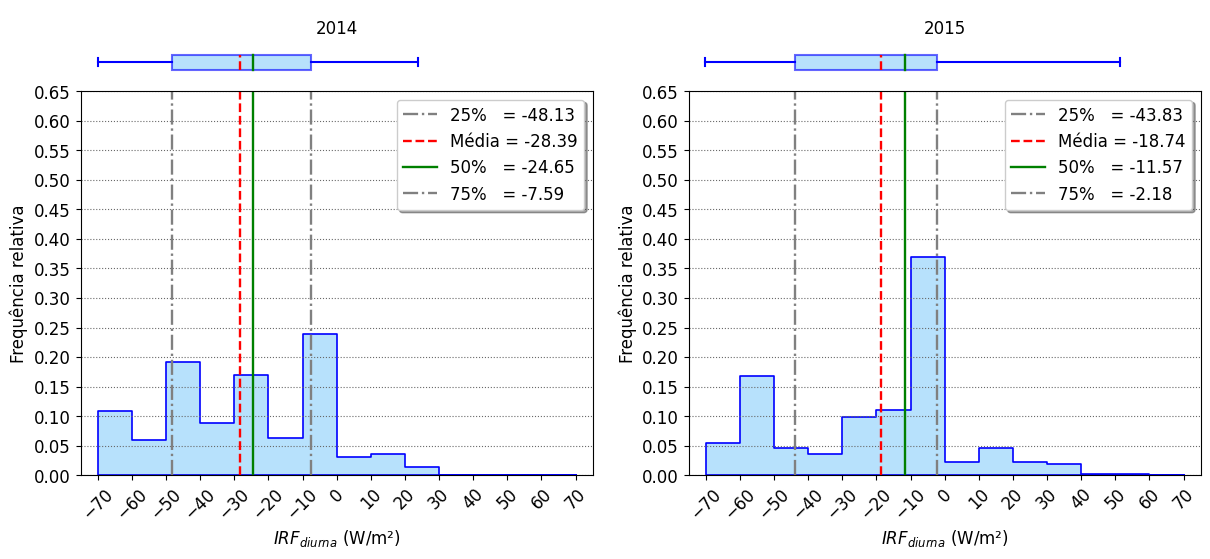

In [59]:
################################################################################# DIURNAS S/ CF:
# histogramas_boxplots_anuais('diurno', irfs_diurnas_semcf14, irfs_diurnas_semcf15, 
#                             ['lightskyblue', 'blue', 'violet', 'blueviolet'], 'sem')
histogramas_boxplots_anuais('diurno', irfs_diurnas_semcf14, irfs_diurnas_semcf15, 
                            ['lightskyblue', 'blue', 'lightskyblue', 'blue'], 'sem')

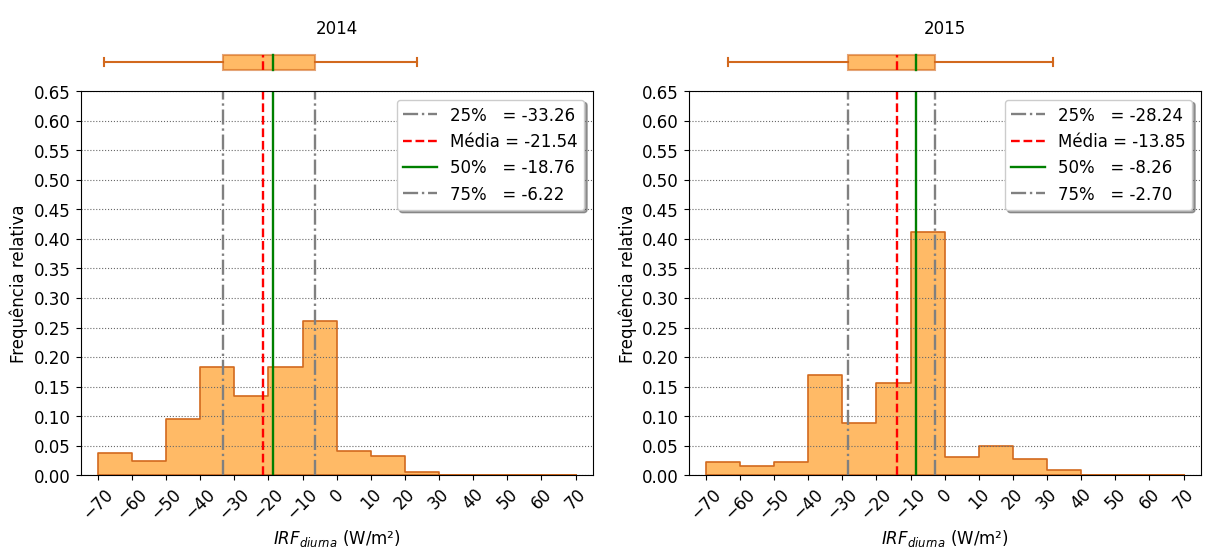

In [60]:
################################################################################# DIURNAS C/ CF:
# histogramas_boxplots_anuais('diurno', irfs_diurnas_semnan_comcf_14, irfs_diurnas_semnan_comcf_15, 
#                             ['darkorange', 'chocolate', 'lightsalmon', 'maroon'], 'com')
# histogramas_boxplots_anuais('diurno', irfs_diurnas_semnan_comcf_14, irfs_diurnas_semnan_comcf_15, 
#                             ['darkorange', 'chocolate', 'slategray', 'k'], 'com')
# histogramas_boxplots_anuais('diurno', irfs_diurnas_comcf14, irfs_diurnas_comcf15, 
#                             ['darkorange', 'chocolate', 'lightgreen', 'limegreen'], 'com')
histogramas_boxplots_anuais('diurno', irfs_diurnas_comcf14, irfs_diurnas_comcf15, 
                            ['darkorange', 'chocolate', 'darkorange', 'chocolate'], 'com')

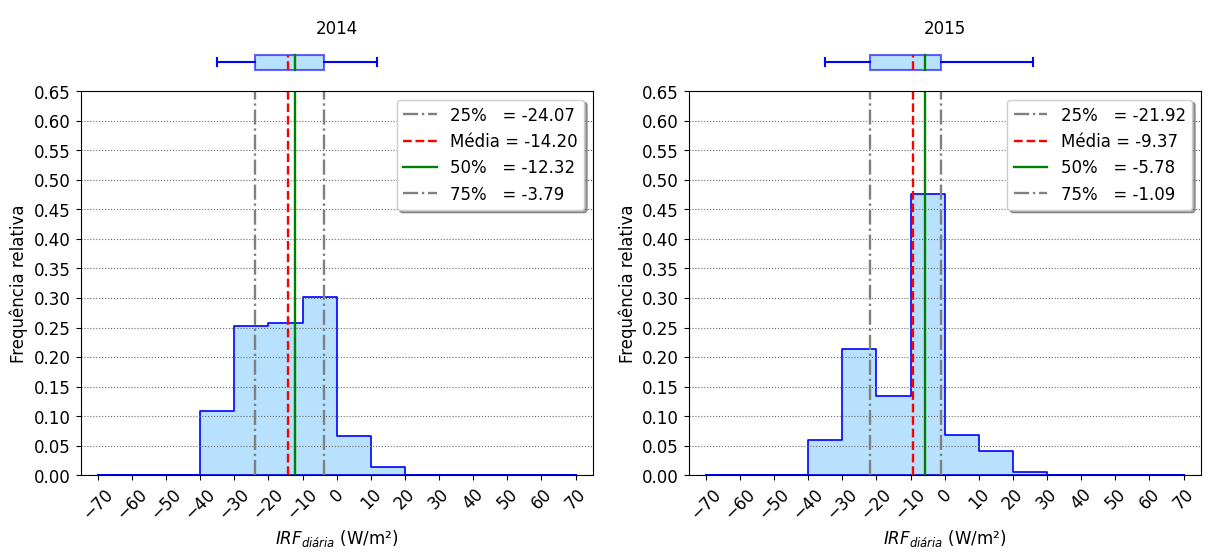

In [61]:
################################################################################# DIÁRIAS S/ CF:
# histogramas_boxplots_anuais('diario', irfs_diarias_semcf14, irfs_diarias_semcf15, 
#                             ['lightskyblue', 'blue', 'violet', 'blueviolet'], 'sem')
histogramas_boxplots_anuais('diario', irfs_diarias_semcf14, irfs_diarias_semcf15, 
                            ['lightskyblue', 'blue', 'lightskyblue', 'blue'], 'sem')

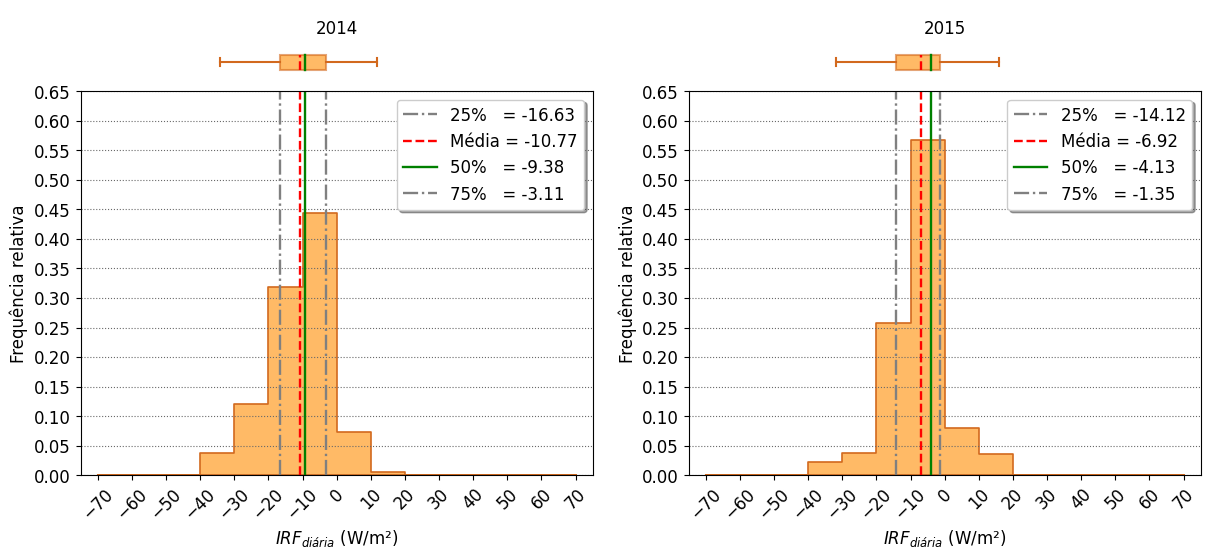

In [62]:
################################################################################# DIÁRIAS C/ CF:
# histogramas_boxplots_anuais('diario', irfs_diarias_semnan_comcf_14, irfs_diarias_semnan_comcf_15, 
#                             ['darkorange', 'chocolate', 'lightsalmon', 'maroon'], 'com')
# histogramas_boxplots_anuais('diario', irfs_diarias_semnan_comcf_14, irfs_diarias_semnan_comcf_15, 
#                             ['darkorange', 'chocolate', 'slategray', 'k'], 'com')
# histogramas_boxplots_anuais('diario', irfs_diarias_comcf14, irfs_diarias_comcf15, 
#                             ['darkorange', 'chocolate', 'lightgreen', 'limegreen'], 'com')
histogramas_boxplots_anuais('diario', irfs_diarias_comcf14, irfs_diarias_comcf15, 
                            ['darkorange', 'chocolate', 'darkorange', 'chocolate'], 'com')

### Construindo as tabelas finais com as estatísticas de 2014 e 2015:

In [57]:
############ 2014:
listao_ano14 = [np.percentile(irfs_diarias_semcf14, 25), 
                np.nanmedian(irfs_diarias_semcf14),
                np.percentile(irfs_diarias_semcf14, 75),
                np.nanmean(irfs_diarias_semcf14),
                np.percentile(irfs_diarias_comcf14, 25),
                np.nanmedian(irfs_diarias_comcf14),
                np.percentile(irfs_diarias_comcf14, 75),
                np.nanmean(irfs_diarias_comcf14)]
listao_cenarios14 = []
for i in range(len(estacoes_diarias_semnan_semcf14)):
    lista = [np.percentile(estacoes_diarias_semnan_semcf14[i], 25),
             np.nanmedian(estacoes_diarias_semnan_semcf14[i]), 
             np.percentile(estacoes_diarias_semnan_semcf14[i], 75),
             np.nanmean(estacoes_diarias_semnan_semcf14[i]),
             np.percentile(estacoes_diarias_semnan_comcf14[i], 25),
             np.nanmedian(estacoes_diarias_semnan_comcf14[i]),
             np.percentile(estacoes_diarias_semnan_comcf14[i], 75),
             np.nanmean(estacoes_diarias_semnan_comcf14[i])]
    listao_cenarios14.append(lista)
listao_sazonas14 = []
for i in range(len(sazonas_diarias_semnan_semcf14)):
    lista = [np.percentile(sazonas_diarias_semnan_semcf14[i], 25),
             np.nanmedian(sazonas_diarias_semnan_semcf14[i]), 
             np.percentile(sazonas_diarias_semnan_semcf14[i], 75),
             np.nanmean(sazonas_diarias_semnan_semcf14[i]),
             np.percentile(sazonas_diarias_semnan_comcf14[i], 25),
             np.nanmedian(sazonas_diarias_semnan_comcf14[i]),
             np.percentile(sazonas_diarias_semnan_comcf14[i], 75),
             np.nanmean(sazonas_diarias_semnan_comcf14[i])]
    listao_sazonas14.append(lista)
listao_trims14 = []
for i in range(len(trims_diarias_semnan_semcf14)):
    lista = [np.percentile(trims_diarias_semnan_semcf14[i], 25),
             np.nanmedian(trims_diarias_semnan_semcf14[i]), 
             np.percentile(trims_diarias_semnan_semcf14[i], 75),
             np.nanmean(trims_diarias_semnan_semcf14[i]),
             np.percentile(trims_diarias_semnan_comcf14[i], 25),
             np.nanmedian(trims_diarias_semnan_comcf14[i]),
             np.percentile(trims_diarias_semnan_comcf14[i], 75),
             np.nanmean(trims_diarias_semnan_comcf14[i])]
    listao_trims14.append(lista)

In [58]:
dicdiarias14 = {'Ano':listao_ano14,
                'Chuvoso':listao_sazonas14[0], 'Transição':listao_sazonas14[1], 'Seco':listao_sazonas14[2],    
                'Limpo':listao_cenarios14[0], 'Transição_1':listao_cenarios14[1], 
                'Poluído_1':listao_cenarios14[2], 'Transição_2':listao_cenarios14[3],
                'Poluído_2':listao_cenarios14[4], 'Transição_3':listao_cenarios14[5],
                'JFM':listao_trims14[0], 'AMJ':listao_trims14[1],
                'JAS':listao_trims14[2], 'OND':listao_trims14[3]}
dfdiarias14 = pd.DataFrame(dicdiarias14)
diarias14final = dfdiarias14.T
diarias14final.columns = ['25%', '50%', '75%', 'Média', '25%', '50%', '75%', 'Média']
diarias14final

,25%,50%,75%,Média,25%,50%,75%,Média
Ano,-24.067328,-12.324921,-3.793911,-14.195258,-16.628648,-9.377540,-3.110783,-10.770905
Chuvoso,-23.251826,-13.149019,-3.965490,-13.665487,-19.532365,-10.585001,-3.174570,-11.219282
Transição,-24.041940,-19.375698,-13.258547,-17.871728,-17.764986,-12.665447,-6.765838,-12.636228
Seco,-31.234888,-28.968213,-20.905921,-24.319341,-20.519409,-18.843786,-13.148099,-16.376864
Limpo,-10.283604,-7.190185,4.227119,-3.793911,-9.075085,-4.478355,3.787467,-3.110783
Transição_1,-19.511467,-14.551320,-4.572856,-12.324921,-14.367128,-9.753800,-3.318043,-9.237494
Poluído_1,-31.717221,-28.277302,-20.899385,-24.067328,-20.527329,-17.398537,-13.095762,-16.628648
Transição_2,-22.601547,-8.484544,-1.689082,-10.572377,-20.321735,-7.040044,-1.685599,-9.377540
Poluído_2,-33.445251,-30.320077,-23.392489,-26.688526,-28.542171,-22.435976,-15.974543,-21.031837
Transição_3,-18.727685,-14.505086,-11.848891,-14.595063,-18.299189,-13.832780,-10.163724,-13.066089


In [59]:
############ 2015:
listao_ano15 = [np.percentile(irfs_diarias_semcf15, 25), 
                np.nanmedian(irfs_diarias_semcf15),
                np.percentile(irfs_diarias_semcf15, 75),
                np.nanmean(irfs_diarias_semcf15),
                np.percentile(irfs_diarias_comcf15, 25),
                np.nanmedian(irfs_diarias_comcf15),
                np.percentile(irfs_diarias_comcf15, 75),
                np.nanmean(irfs_diarias_comcf15)]
listao_cenarios15 = []
for i in range(len(estacoes_diarias_semnan_semcf15)):
    lista = [np.percentile(estacoes_diarias_semnan_semcf15[i], 25),
             np.nanmedian(estacoes_diarias_semnan_semcf15[i]), 
             np.percentile(estacoes_diarias_semnan_semcf15[i], 75),
             np.nanmean(estacoes_diarias_semnan_semcf15[i]),
             np.percentile(estacoes_diarias_semnan_comcf15[i], 25),
             np.nanmedian(estacoes_diarias_semnan_comcf15[i]),
             np.percentile(estacoes_diarias_semnan_comcf15[i], 75),
             np.nanmean(estacoes_diarias_semnan_comcf15[i])]
    listao_cenarios15.append(lista)

lista1 = [np.percentile(sazonas_diarias_semnan_semcf15[0], 25),
          np.nanmedian(sazonas_diarias_semnan_semcf15[0]), 
          np.percentile(sazonas_diarias_semnan_semcf15[0], 75),
          np.nanmean(sazonas_diarias_semnan_semcf15[0]),
          np.percentile(sazonas_diarias_semnan_comcf15[0], 25),
          np.nanmedian(sazonas_diarias_semnan_comcf15[0]),
          np.percentile(sazonas_diarias_semnan_comcf15[0], 75),
          np.nanmean(sazonas_diarias_semnan_comcf15[0])]
lista2 = [np.percentile(sazonas_diarias_semnan_semcf15[2], 25),
          np.nanmedian(sazonas_diarias_semnan_semcf15[2]), 
          np.percentile(sazonas_diarias_semnan_semcf15[2], 75),
          np.nanmean(sazonas_diarias_semnan_semcf15[2]),
          np.percentile(sazonas_diarias_semnan_comcf15[2], 25),
          np.nanmedian(sazonas_diarias_semnan_comcf15[2]),
          np.percentile(sazonas_diarias_semnan_comcf15[2], 75),
          np.nanmean(sazonas_diarias_semnan_comcf15[2])]
listao_sazonas15 = [lista1, lista2]
    
listao_trims15 = []
for i in range(len(trims_diarias_semnan_semcf15)):
    lista = [np.percentile(trims_diarias_semnan_semcf15[i], 25),
             np.nanmedian(trims_diarias_semnan_semcf15[i]), 
             np.percentile(trims_diarias_semnan_semcf15[i], 75),
             np.nanmean(trims_diarias_semnan_semcf15[i]),
             np.percentile(trims_diarias_semnan_comcf15[i], 25),
             np.nanmedian(trims_diarias_semnan_comcf15[i]),
             np.percentile(trims_diarias_semnan_comcf15[i], 75),
             np.nanmean(trims_diarias_semnan_comcf15[i])]
    listao_trims15.append(lista)

In [60]:
dicdiarias15 = {'Ano':listao_ano15,
                'Chuvoso':listao_sazonas15[0], 'Seco':listao_sazonas15[1],    
                'Limpo':listao_cenarios15[0], 'Transição_1':listao_cenarios15[1],'Poluído':listao_cenarios15[2],
                'JFM':listao_trims15[0], 'AMJ':listao_trims15[1],
                'JAS':listao_trims15[2], 'OND':listao_trims15[3]}
dfdiarias15 = pd.DataFrame(dicdiarias15)
diarias15final = dfdiarias15.T
diarias15final.columns = ['25%', '50%', '75%', 'Média', '25%', '50%', '75%', 'Média']
diarias15final

,25%,50%,75%,Média,25%,50%,75%,Média
Ano,-21.915968,-5.782713,-1.090351,-9.369654,-14.119077,-4.131467,-1.351298,-6.924564
Chuvoso,-9.505295,-5.371993,7.202203,-1.090351,-8.275470,-4.314011,6.303963,-1.351298
Seco,-29.153385,-22.334456,-12.465154,-20.007753,-19.500605,-14.340232,-5.865127,-13.905690
Limpo,-9.505295,-5.371993,7.202203,-1.090351,-8.275470,-4.314011,6.303963,-1.351298
Transição_1,-20.576128,-12.465154,-5.653827,-12.691406,-11.953715,-5.865127,-3.089430,-7.114524
Poluído,-30.804596,-27.552022,-21.481832,-25.045238,-22.962907,-18.704402,-14.340678,-18.581575
JFM,-9.631114,-7.271470,6.420843,-2.287643,-8.550058,-5.705321,5.746847,-2.315934
AMJ,-2.166843,8.423048,13.014312,6.093398,-1.719734,5.606693,10.613095,4.436514
JAS,-21.924018,-13.645253,-6.120024,-13.717531,-12.658849,-6.551108,-3.228270,-7.771542
OND,-31.758232,-28.066587,-21.481669,-25.287047,-24.848319,-18.967839,-14.516026,-19.053993


In [61]:
pasta = '/mnt/HD_500GB_WD/historia2/Z-Copia_Notebooks_selecionados-Final/'
diarias14final.to_csv(pasta+'TabelaEstatisticasDiarias2014.csv')
diarias15final.to_csv(pasta+'TabelaEstatisticasDiarias2015.csv')